# Use examples of [edges](https://github.com/romainsacchi/edges)

Author: [romainsacchi](https://github.com/romainsacchi)

This notebook shows examples on how to use `edge` to use exchange-specific
characterization factors in the characterization matrix of `bw2calc`, combining the use of exchange names and custom functions.

## Requirements

* **Pyhton 3.10 or higher (up to 3.11) is highly recommended**

# Use case with [brightway2](https://brightway.dev/)

`brightway2` is an open source LCA framework for Python.
To use `premise` from `brightway2`, it requires that you have an activated `brightway2` project with a `biosphere3` database as well as an [ecoinvent](https://ecoinvent.prg) v.3 cut-off or consequential database registered in that project. Please refer to the brightway [documentation](https://brightway.dev) if you do not know how to create a project and install ecoinvent.

In [1]:
from edges import EdgeLCIA, get_available_methods
import bw2data

In this example, we will consider a more complex use of parameters based on thre previous example (saved under `lcia_example_4.json`) together with user-defined functions.
Here, we define the CF for methane and dinitrogen monoxide based on `H` (time horizon) and the gas concentration.

In [2]:
import numpy as np

# Physical constants
M_atm = 5.15e18  # kg, total mass of Earth's atmosphere
M_air = 28.96    # g/mol, average molar mass of air

# Gas-specific molecular weights (g/mol)
M_gas = {
    'CO2': 44.01,
    'CH4': 16.04,
    'N2O': 44.013
}

# IPCC concentration parameters (Myhre et al. 1998 / IPCC AR6)
RF_COEFF = {
    'CH4': 0.036,  # W·m⁻²·ppb⁻½ for CH4
    'N2O': 0.12    # W·m⁻²·ppb⁻½ for N2O
}

# Reference atmospheric concentrations (IPCC AR6, ~2019)
C_REF = {
    'CH4': 1866,  # ppb
    'N2O': 332    # ppb
}

# Indirect forcing factor for methane (IPCC AR6)
INDIRECT_FACTOR = {
    'CH4': 1.65,
    'N2O': 1.0
}

# Gas-specific atmospheric lifetimes (years, IPCC AR6)
TAU_GAS = {
    'CH4': 11.8,
    'N2O': 109
}

# CO2 impulse response function parameters (IPCC AR5/AR6)
CO2_IRF = {
    'a0': 0.2173,
    'a': [0.2240, 0.2824, 0.2763],
    'tau': [394.4, 36.54, 4.304]
}

# Convert concentration-based radiative efficiency to mass-based (W·m⁻²·kg⁻¹)
def convert_ppb_to_mass_rf(a_ppb, gas):
    return a_ppb * (M_atm / M_gas[gas]) * (M_air / 1e9)

# Calculate concentration-dependent radiative efficiency
def radiative_efficiency_concentration(gas, concentration_ppb):
    alpha = RF_COEFF[gas]
    return (alpha / (2 * np.sqrt(concentration_ppb))) * INDIRECT_FACTOR[gas]

# AGWP for CO2 (mass-based)
def AGWP_CO2(H):
    integral_CO2 = CO2_IRF['a0'] * H + sum(
        a * tau * (1 - np.exp(-H / tau))
        for a, tau in zip(CO2_IRF['a'], CO2_IRF['tau'])
    )
    am_CO2 = convert_ppb_to_mass_rf(1.37e-5, 'CO2')  # fixed IPCC radiative efficiency for CO2
    return am_CO2 * integral_CO2

# AGWP for gas at given concentration
def AGWP_gas(gas, H, concentration_ppb):
    aa_gas = radiative_efficiency_concentration(gas, concentration_ppb)
    am_gas = convert_ppb_to_mass_rf(aa_gas, gas)
    tau_gas = TAU_GAS[gas]
    return am_gas * tau_gas * (1 - np.exp(-H / tau_gas))

# Calculate concentration-dependent GWP
def GWP(gas, H, concentration_ppb):
    AGWP_g = AGWP_gas(gas, H, concentration_ppb)
    AGWP_ref = AGWP_CO2(H)
    return AGWP_g / AGWP_ref


In [3]:
GWP('CH4', 100, 1911)

30.660731597024444

We do not get exactly 28 for H=100, as the IPCC does, because there are some carbon feedback loops and other kind of complex and non-linear interactions that are not considered in this simple model.

Our JSON file looks like this below. This time, we call `GWP()` and pass it a few parameters (e.g., gas type, time horizon, and gas concentration). Note the presence of a **scenarios** section at the bottom.

In [4]:
{
  "name": [
    "Parameterized GWP method"
  ],
  "unit": "kg CO2-eq",
  "description": "Parameterized GWP factors.",
  "version": "1.0",
  "exchanges": [
    {
      "supplier": {
        "name": "Carbon dioxide",
        "operator": "startswith",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
        "type": "process"
      },
      "value": "1.0"
    },
    {
        "supplier": {
          "name": "Methane, fossil",
          "operator": "contains",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
          "type": "process"
        },
        "value": "GWP('CH4',H, C_CH4)"
      },
    {
      "supplier": {
        "name": "Dinitrogen monoxide",
        "operator": "equals",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
        "type": "process"
      },
      "value": "GWP('N2O',H, C_N2O)"
    }
  ],
  "scenarios": {
    "RCP1.9": {
      "C_CH4": {
        "2020": 1866,
        "2050": 1428,
        "2080": 1150,
        "2100": 1036
      },
      "C_N2O": {
        "2020": 332,
        "2050": 344,
        "2080": 350,
        "2100": 354
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    }
  }
}

{'name': ['Parameterized GWP method'],
 'unit': 'kg CO2-eq',
 'description': 'Parameterized GWP factors.',
 'version': '1.0',
 'exchanges': [{'supplier': {'name': 'Carbon dioxide',
    'operator': 'startswith',
    'matrix': 'biosphere'},
   'consumer': {'matrix': 'technosphere', 'type': 'process'},
   'value': '1.0'},
  {'supplier': {'name': 'Methane, fossil',
    'operator': 'contains',
    'matrix': 'biosphere'},
   'consumer': {'matrix': 'technosphere', 'type': 'process'},
   'value': "GWP('CH4',H, C_CH4)"},
  {'supplier': {'name': 'Dinitrogen monoxide',
    'operator': 'equals',
    'matrix': 'biosphere'},
   'consumer': {'matrix': 'technosphere', 'type': 'process'},
   'value': "GWP('N2O',H, C_N2O)"}],
 'scenarios': {'RCP1.9': {'C_CH4': {'2020': 1866,
    '2050': 1428,
    '2080': 1150,
    '2100': 1036},
   'C_N2O': {'2020': 332, '2050': 344, '2080': 350, '2100': 354},
   'H': {'2020': 100, '2050': 100, '2080': 100, '2100': 100}}}}

We can instantiate the EdgeLCIA() class as usual, except that we need to pass the parameters as a dictionary.
Then we proceed to the mapping steps. Finally, we iterate over the scenarios and evaluate the CFs.

In [5]:
# activate the bw project
bw2data.projects.set_current("ecoinvent-3.10.1-cutoff")
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
act

'market for natural gas, high pressure' (cubic meter, IT, None)

In [6]:
import numpy as np

# GWP and LCIA setup
allowed_funcs = {"GWP": GWP}
method = ('GWP', 'scenario-dependent', '100 years')

all_results = []  # To collect results

# Initialize LCIA
lcia = EdgeLCIA(
    demand={act: 1},
    filepath="lcia_parameterized_gwp.json",
    scenario="RCP1.9",
    allowed_functions=allowed_funcs
)

# Usual LCIA steps
lcia.lci()
lcia.map_exchanges()

results = []
# Loop over scenarios
for scenario in [
    "RCP1.9",
    "RCP2.6",
    "RCP4.5",
    "RCP8.5",
]:
    for year in [
        "2020",
        "2050",
        "2080",
        "2100",
    ]:
        print(scenario, year)
        lcia.evaluate_cfs(scenario=scenario, scenario_idx=year)
        lcia.lcia()
        df = lcia.generate_cf_table()

        scenario_result = {
            "year": int(year),
            "rcp": scenario,
            "score": lcia.score,
            "CF_table": df
        }
        all_results.append(scenario_result)

        print(f"Year {year} | {scenario}: Impact = {lcia.score}")

/Users/romain/micromamba/envs/ab/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.83e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


12788 processed biosphere edges
0 processed technosphere edges
RCP1.9 2020
Year 2020 | RCP1.9: Impact = 0.7071294744191221
RCP1.9 2050
Year 2050 | RCP1.9: Impact = 0.7576945854870091
RCP1.9 2080
Year 2080 | RCP1.9: Impact = 0.8038844194799897
RCP1.9 2100
Year 2100 | RCP1.9: Impact = 0.8280048394943881
RCP2.6 2020
Year 2020 | RCP2.6: Impact = 0.7071294744191221
RCP2.6 2050
Year 2050 | RCP2.6: Impact = 0.7454024813690878
RCP2.6 2080
Year 2080 | RCP2.6: Impact = 0.7949573215921886
RCP2.6 2100
Year 2100 | RCP2.6: Impact = 0.8234903526073307
RCP4.5 2020
Year 2020 | RCP4.5: Impact = 0.7071294744191221
RCP4.5 2050
Year 2050 | RCP4.5: Impact = 0.6933240800118989
RCP4.5 2080
Year 2080 | RCP4.5: Impact = 0.7155682735042111
RCP4.5 2100
Year 2100 | RCP4.5: Impact = 0.7257424089919026
RCP8.5 2020
Year 2020 | RCP8.5: Impact = 0.7071294744191221
RCP8.5 2050
Year 2050 | RCP8.5: Impact = 0.6623158735531743
RCP8.5 2080
Year 2080 | RCP8.5: Impact = 0.6500295141405903
RCP8.5 2100
Year 2100 | RCP8.5: Impac

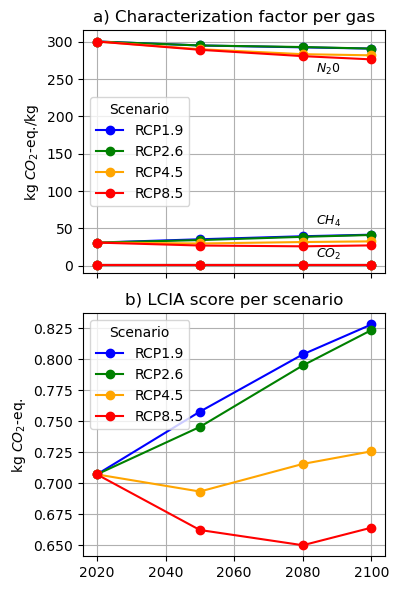

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Turn all_results into a DataFrame
df = pd.DataFrame(all_results)

# Make sure year is numeric
df["year"] = df["year"].astype(int)

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

# ---- Top plot: GWP factor per gas ----

# Gases to track
gases_of_interest = ["Carbon dioxide, fossil", "Methane, fossil", "Dinitrogen monoxide"]

# Colors per RCP
rcp_colors = {
    "RCP1.9": "blue",
    "RCP2.6": "green",
    "RCP4.5": "orange",
    #"RCP6.0": "orange",
    "RCP8.5": "red"
}

# Create empty dataframe to collect
gas_cf_data = []

# Loop over results
for res in all_results:
    year = res["year"]
    rcp = res["rcp"]
    cf_table = res["CF_table"]
    
    # Filter for only gases of interest
    cf_filtered = cf_table[cf_table["supplier name"].isin(gases_of_interest)]
    
    # For each gas separately
    for gas in gases_of_interest:
        cf_gas = cf_filtered[cf_filtered["supplier name"] == gas]
        if not cf_gas.empty:
            avg_cf = cf_gas["CF"].mean()
            gas_cf_data.append({
                "year": year,
                "rcp": rcp,
                "gas": gas,
                "avg_CF": avg_cf
            })

# Convert to DataFrame
df_gas_cf = pd.DataFrame(gas_cf_data)

# Plot: one line per gas and RCP, with RCP color
for gas in gases_of_interest:
    for rcp in df_gas_cf["rcp"].unique():
        df_plot = df_gas_cf[(df_gas_cf["gas"] == gas) & (df_gas_cf["rcp"] == rcp)]
        ax1.plot(df_plot["year"], df_plot["avg_CF"], marker='o', color=rcp_colors[rcp])

# ---- Add manual annotations for gases ----

# Pick a representative point for each gas (e.g., latest year, latest scenario)
for gas in gases_of_interest:
    df_gas = df_gas_cf[(df_gas_cf["gas"] == gas) & (df_gas_cf["rcp"] == "RCP8.5")]  # Pick RCP8.5 to annotate at right
    if not df_gas.empty:
        latest_point = df_gas[df_gas["year"] == df_gas["year"].max()]
        x = latest_point["year"].values[0]
        y = latest_point["avg_CF"].values[0]
        gas = gas.replace(", fossil", "")
        if gas=="Dinitrogen monoxide":
            gas = "$N_2$0"
            ax1.annotate(gas.replace(" ", "\n"), (x, y),
                         textcoords="offset points", xytext=(-40,-10), ha='left', fontsize=9)
        elif gas == "Methane":
            gas = "$CH_4$"
            ax1.annotate(gas.replace(" ", "\n"), (x, y),
                         textcoords="offset points", xytext=(-40,15), ha='left', fontsize=9)
        else:
            gas = "$CO_2$"
            ax1.annotate(gas.replace(" ", "\n"), (x, y),
                         textcoords="offset points", xytext=(-40,5), ha='left', fontsize=9)

# ---- Custom legend only for RCPs ----

custom_lines = [
    mlines.Line2D([], [], color="blue", marker='o', linestyle='-', label="RCP1.9"),
    mlines.Line2D([], [], color="green", marker='o', linestyle='-', label="RCP2.6"),
    mlines.Line2D([], [], color="orange", marker='o', linestyle='-', label="RCP4.5"),
    mlines.Line2D([], [], color="red", marker='o', linestyle='-', label="RCP8.5"),
]
ax1.legend(handles=custom_lines, title="Scenario", loc="center left")

ax1.set_title("a) Characterization factor per gas")
ax1.set_ylabel("kg $CO_2$-eq./kg")
ax1.grid(True)
ax1.set_ylim(bottom=-10)

# ---- Bottom plot: LCIA Scores ----

for rcp in df["rcp"].unique():
    df_rcp = df[df["rcp"] == rcp]
    ax2.plot(df_rcp["year"], df_rcp["score"], marker='o', color=rcp_colors[rcp], label=rcp)

ax2.set_title("b) LCIA score per scenario")
ax2.set_xlabel("")
ax2.set_ylabel("kg $CO_2$-eq.")
#ax2.set_ylim(1.6, 1.8)
ax2.grid(True)
ax2.legend(title="Scenario")

plt.tight_layout()
plt.savefig("figure_3.png", bbox_inches="tight", dpi=150)
plt.show()
